In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['rice-diseases-image-dataset']


In [3]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [4]:
#Define the data directory
data_dir = '../input/rice-diseases-image-dataset/LabelledRice/Labelled/'

In [10]:
from glob import glob
images = glob(os.path.join(data_dir, '*/*.jpg'))
tot_images = len(images)
print('Total images:', tot_images)

Total images: 3355


In [11]:
tot_images = 3355
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder
        
num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))


Class             Count
------------------------
Hispa                565
Healthy              1488
BrownSpot            523
LeafBlast            779
Total number of classes: 4


In [5]:
# Define transforms for the training and validation sets
data_transforms ={
    "train_transforms": transforms.Compose([transforms.Resize(224),
                                           transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224), 
                                           transforms.RandomHorizontalFlip(), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406], 
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]), 
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

In [6]:
# Split the dataset into train, validation and test
train_data = 0.8
valid_data = 0.1
test_data = 0.1

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])#loading dataset
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
train_count = int(0.8*num_train)
valid_count = int(0.1*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))

2684 335 336
Training 2684 0.8
Validation 335 0.09985096870342772
Test 336 0.10014903129657228


In [7]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [8]:
# Define the dataloaders using the image datasets. Dataloader is used to load our data in batches
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)

In [9]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization

In [10]:
classes=['LeafBlast', 'BrownSpot', 'Healthy', 'Hispa']

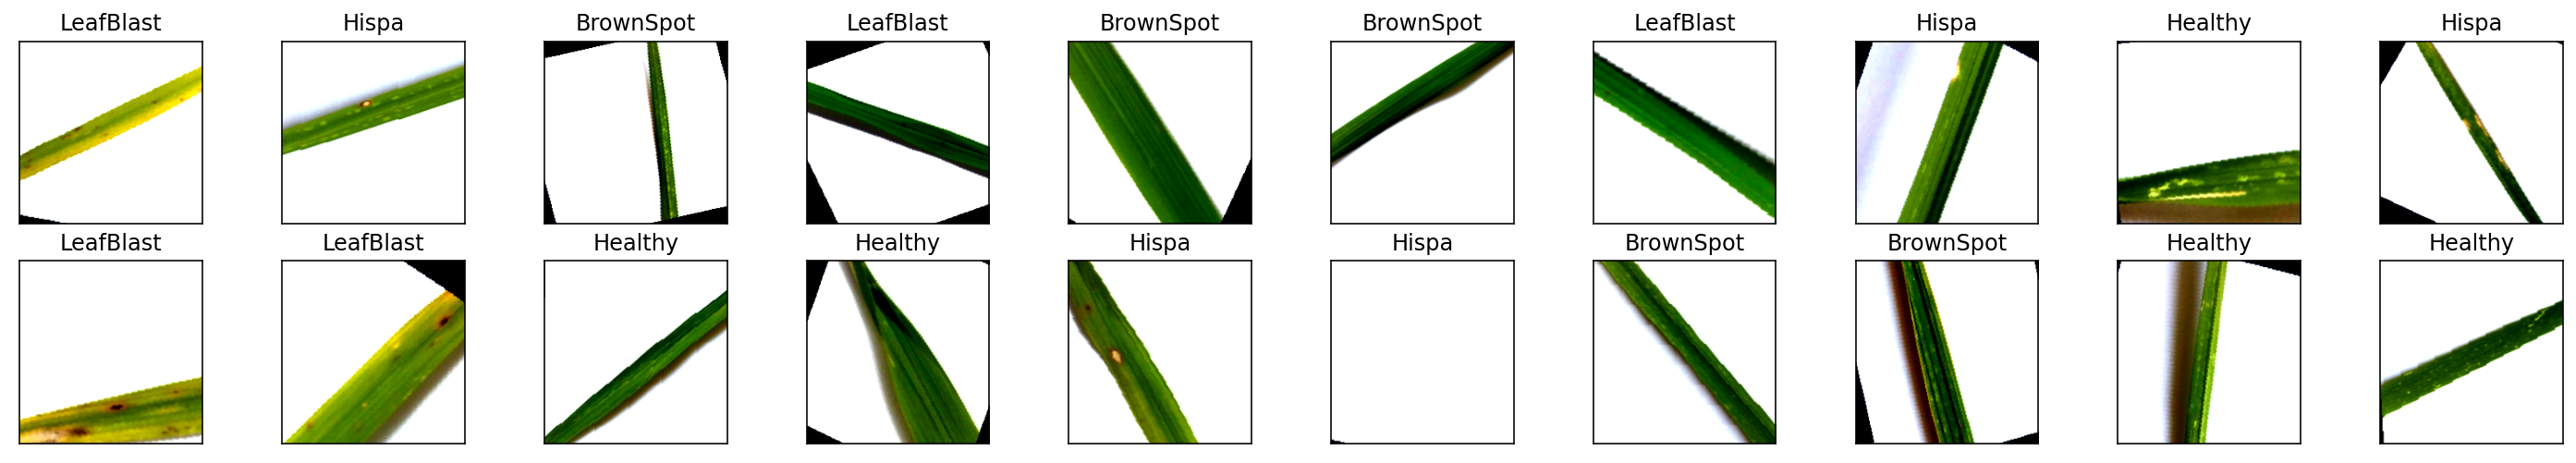

In [11]:
#Visualize some sample data
#Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() #convert images to numpy for display

#Plot the images in the batch, along with corresponding labels
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(str(labels[idx].item()))
    ax.set_title(classes[labels[idx]])

# googlenet

In [14]:
# Specify model architecture
# Load the pretrained model from pytorch's library and stored it in model_transfer
model_transfer = models.googlenet(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [24]:
#print the model to see all the layers
print(model_transfer)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
#Lets read the fully connected layer
print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

1024
1000


In [26]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [27]:
# Define n_inputs takes the same number of inputs from pre-trained model
n_inputs = model_transfer.fc.in_features #refer to the fully connected layer only

# Add last linear layer (n_inputs -> 4 classes). In this case the ouput is 4 classes
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.fc = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()
  
# Check to see the last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

4


In [30]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

# vgg

In [12]:
# Specify model architecture
# Load the pretrained model from pytorch's library and stored it in model_transfer
model_vgg16 = models.vgg16(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_vgg16 = model_vgg16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [13]:
#print the model to see all the layers
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for param in model_vgg16.parameters():
    param.requires_grad=True

In [15]:

model_vgg16.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 512), 
                      nn.ReLU(), 
                      nn.Dropout(0.5),
                      nn.Linear(512, 4))

# If GPU is available, move the model to GPU
if use_cuda:
    model_vgg16 = model_vgg16.cuda()
  

 # Observe that all parameters are being optimized
criterion_vgg = nn.CrossEntropyLoss()

optimizer_vgg = optim.SGD(model_vgg16.parameters(), lr=0.001, momentum=0.9)



# Check to see the last layer produces the expected number of outputs
print(model_vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# training

In [16]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf
  
    for epoch in range(1, n_epochs+1):
        # In the training loop, I track down the loss
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
        # Model training
        model.train()

        for batch_idx, (data,target) in enumerate(trainloader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()

      
            # Then, clear (zero out) the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))
            print('epoch',epoch,'batch',batch_idx)
      
        # Model validation
        model.eval()
        
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))
      
        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))
    
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
  
    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}



### googlenet  training

In [ ]:
# Train the model
model_transfer = train(50, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


epoch 1 batch 0
epoch 1 batch 1
epoch 1 batch 2
epoch 1 batch 3
epoch 1 batch 4
epoch 1 batch 5
epoch 1 batch 6
epoch 1 batch 7
epoch 1 batch 8
epoch 1 batch 9
epoch 1 batch 10
epoch 1 batch 11
epoch 1 batch 12
epoch 1 batch 13
epoch 1 batch 14
epoch 1 batch 15
epoch 1 batch 16
epoch 1 batch 17
epoch 1 batch 18
epoch 1 batch 19
epoch 1 batch 20
epoch 1 batch 21
epoch 1 batch 22
epoch 1 batch 23
epoch 1 batch 24
epoch 1 batch 25
epoch 1 batch 26
epoch 1 batch 27
epoch 1 batch 28
epoch 1 batch 29
epoch 1 batch 30
epoch 1 batch 31
epoch 1 batch 32
epoch 1 batch 33
epoch 1 batch 34
epoch 1 batch 35
epoch 1 batch 36
epoch 1 batch 37
epoch 1 batch 38
epoch 1 batch 39
epoch 1 batch 40
epoch 1 batch 41
epoch 1 batch 42
epoch 1 batch 43
epoch 1 batch 44
epoch 1 batch 45
epoch 1 batch 46
epoch 1 batch 47
epoch 1 batch 48
epoch 1 batch 49
epoch 1 batch 50
epoch 1 batch 51
epoch 1 batch 52
Epoch: 1 	Training Loss: 0.93289 	Validation Loss: 0.93871
Validation loss decreased (inf --> 0.93871). Savin

In [62]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### vgg16 training

In [18]:
model_vgg16 = train(50, loaders_transfer, model_vgg16, optimizer_vgg, criterion_vgg, use_cuda, 'model_vgg16.pt')

epoch 1 batch 0
epoch 1 batch 1
epoch 1 batch 2
epoch 1 batch 3
epoch 1 batch 4
epoch 1 batch 5
epoch 1 batch 6
epoch 1 batch 7
epoch 1 batch 8
epoch 1 batch 9
epoch 1 batch 10
epoch 1 batch 11
epoch 1 batch 12
epoch 1 batch 13
epoch 1 batch 14
epoch 1 batch 15
epoch 1 batch 16
epoch 1 batch 17
epoch 1 batch 18
epoch 1 batch 19
epoch 1 batch 20
epoch 1 batch 21
epoch 1 batch 22
epoch 1 batch 23
epoch 1 batch 24
epoch 1 batch 25
epoch 1 batch 26
epoch 1 batch 27
epoch 1 batch 28
epoch 1 batch 29
epoch 1 batch 30
epoch 1 batch 31
epoch 1 batch 32
epoch 1 batch 33
epoch 1 batch 34
epoch 1 batch 35
epoch 1 batch 36
epoch 1 batch 37
epoch 1 batch 38
epoch 1 batch 39
epoch 1 batch 40
epoch 1 batch 41
epoch 1 batch 42
epoch 1 batch 43
epoch 1 batch 44
epoch 1 batch 45
epoch 1 batch 46
epoch 1 batch 47
epoch 1 batch 48
epoch 1 batch 49
epoch 1 batch 50
epoch 1 batch 51
epoch 1 batch 52
Epoch: 1 	Training Loss: 1.02931 	Validation Loss: 1.31984
Validation loss decreased (inf --> 1.31984). Savin

In [22]:
model_vgg16.load_state_dict(torch.load('./model_vgg16.pt'))

<All keys matched successfully>

# testing

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to 
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### testing googlenet

In [63]:
# call test function    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.123489


Test Accuracy: 96% (323/336)


In [ ]:
#Obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy

#Move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()
    
#Get sample outputs
output= model_transfer(images)

#Convert output probabilities to predicted class
_,preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

#Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(30,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))

### testing vgg

In [24]:
test(loaders_transfer, model_vgg16 , criterion_vgg, use_cuda)

Test Loss: 0.119069


Test Accuracy: 95% (322/336)


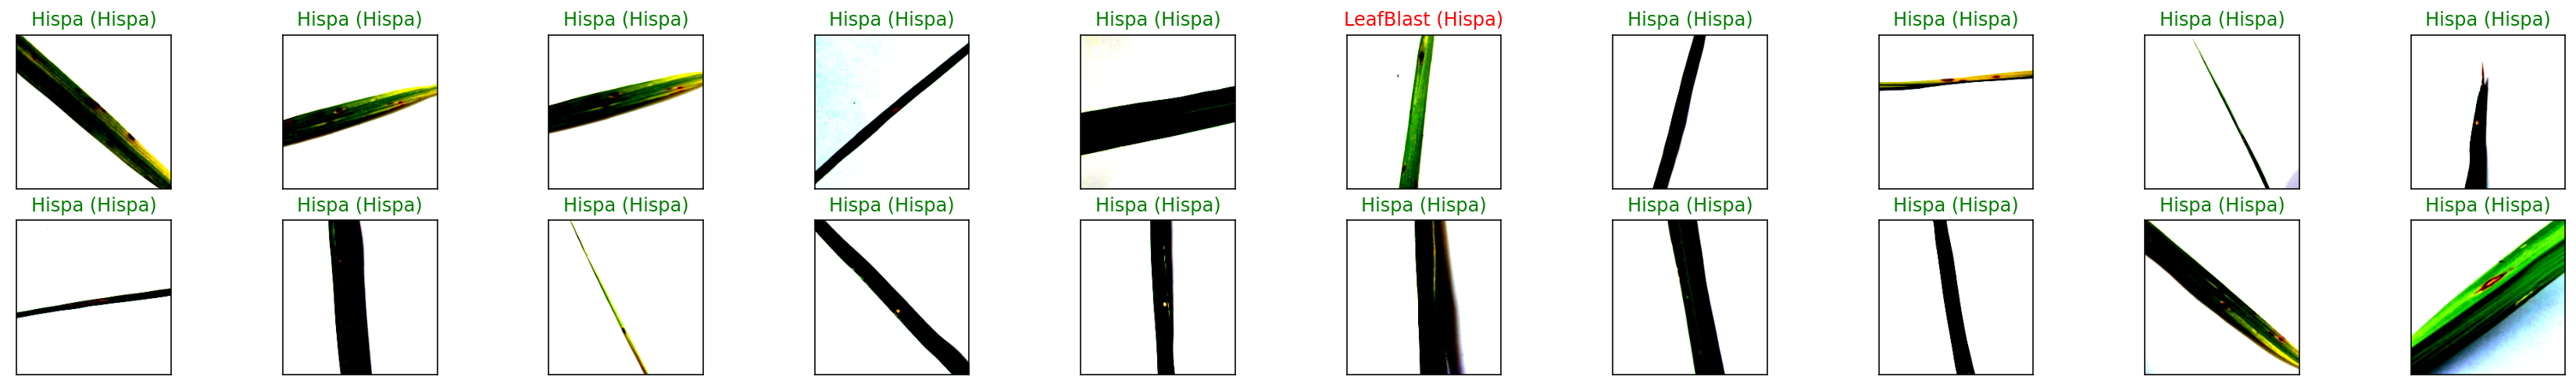

In [26]:
#Obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy

#Move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()
    
#Get sample outputs
output= model_vgg16(images)

#Convert output probabilities to predicted class
_,preds_tensor = torch.max(output,1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

#Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(30,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images.cpu()[idx], (1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))

In [66]:
import torch
import torchvision
import pickle
PATH = "./model_transfer.pt"
pytorch_model = torch.load(PATH)

outfile = "export.pkl"
with open(outfile, 'wb') as pickle_file:
    pickle.dump(pytorch_model, pickle_file)